In [1]:

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display, clear_output
device = "cuda:7" if torch.cuda.is_available() else "cpu"

# Load the pre-trained Stable Diffusion model from the diffusers library
model_id = "stabilityai/stable-diffusion-2-1-base"
# model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

# Set the model to evaluation mode and use GPU if available
pipe = pipe.to(device)

# Configure the DDIM scheduler
scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# Number of sampling steps
num_inference_steps = 50

# Generate initial random noise
batch_size = 1
height = 512  # Height of the generated image
width = 512  # Width of the generated image
# height = 768  # Height of the generated image
# width = 768  # Width of the generated image

# Init noise 
latents_shape = (batch_size, 4, height // 8, width // 8)
S_ch = 1e-3

# Guidance scale (CFG)
guidance_scale = 8

# Perform DDIM sampling
scheduler.set_timesteps(num_inference_steps)
alphas = (scheduler.alphas_cumprod ** 0.5).to(device)
lambdas = ((1 - scheduler.alphas_cumprod) ** 0.5/scheduler.alphas_cumprod ** 0.5).to(device)
alphas_finial = (scheduler.final_alpha_cumprod ** 0.5).to(device)
lambdas_finial = ((1 - scheduler.final_alpha_cumprod) ** 0.5/scheduler.final_alpha_cumprod ** 0.5).to(device)

# GAMMA
def gamma(i):
    # return 0
    if i<num_inference_steps*0.9 and i>num_inference_steps*0.1:
        return S_ch/num_inference_steps
    else:
        return 0

Error No module named 'triton'


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
latents_0 = torch.randn(latents_shape, device=device)

In [3]:
# Define prompt
# prompt = "A DSLR photo of A 3D model of an adorable cottage with a thatched roof"
prompt = "A pirate galleon with a bioluminescent hull that glows faintly in the dark ocean waters, illuminating the ship's intricate carvings and sails as it silently navigates the waves"
negative_prompt = ""

# Tokenize the prompt
input_ids = pipe.tokenizer(prompt, return_tensors="pt").input_ids.to(device)
uncond_input_ids = pipe.tokenizer(negative_prompt, return_tensors="pt").input_ids.to(device)
scheduler.config.prediction_type

'epsilon'

## Diffusion SDE Sampler

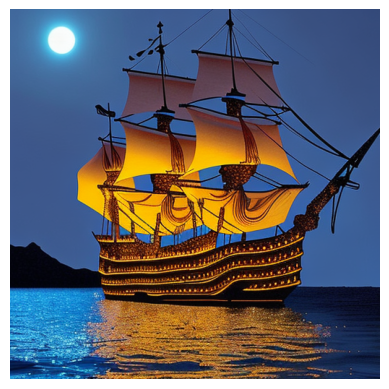

In [4]:
# Generator for SDE Noise
seed = 42
ddpm_generator = torch.Generator(device).manual_seed(seed)
    
for i, t in enumerate(scheduler.timesteps):
    t_hat = (t * (1+gamma(i))).int()
    t_prev = t - scheduler.config.num_train_timesteps // scheduler.num_inference_steps 
    lambda_t = lambdas[t]
    lambda_t_hat = lambdas[t_hat]
    lambda_t_prev = lambdas[t_prev] if t_prev>0 else lambdas_finial
    alpha_t_hat = alphas[t_hat]
    
    # Init latent
    if i==0:
        latents = latents_0*lambda_t
        
    new_noise = torch.randn(latents_shape, generator=ddpm_generator, device=device)
    latents_hat = latents + (lambda_t_hat**2-lambda_t**2)**0.5 * new_noise
    
    with torch.no_grad():
        cond_noise_pred = pipe.unet(alpha_t_hat*latents_hat, t_hat, encoder_hidden_states=pipe.text_encoder(input_ids)[0]).sample
        uncond_noise_pred = pipe.unet(alpha_t_hat*latents_hat, t_hat, encoder_hidden_states=pipe.text_encoder(uncond_input_ids)[0]).sample
        noise_pred = cond_noise_pred + guidance_scale * (cond_noise_pred - uncond_noise_pred)
        if scheduler.config.prediction_type == "v_prediction":
            noise_pred = alpha_t_hat * (noise_pred + lambda_t_hat * alpha_t_hat* latents_hat)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = latents_hat + (lambda_t_prev-lambda_t_hat) * noise_pred
    
    if i % 10 == 9:
        pass
        # Decode the latents to an image
        with torch.no_grad():
            image = pipe.decode_latents(alpha_t_hat*latents)

        from matplotlib import pyplot as  plt
        clear_output(wait=True)
        plt.imshow(image[0])
        plt.axis('off')  # Hide axes
        plt.show()

## Clean Flow SDE Sampler

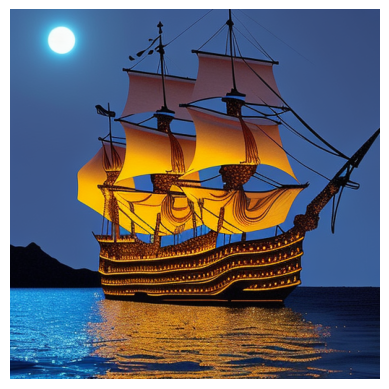

In [5]:
# Generator for SDE Noise
seed = 42
ddpm_generator = torch.Generator(device).manual_seed(seed)
    
# Init latent
latents = torch.zeros_like(latents_0)
noise_add = latents_0
for i, t in enumerate(scheduler.timesteps):
    t_hat = (t * (1+gamma(i))).int()
    t_prev = t - scheduler.config.num_train_timesteps // scheduler.num_inference_steps 
    lambda_t = lambdas[t]
    lambda_t_hat = lambdas[t_hat]
    lambda_t_prev = lambdas[t_prev] if t_prev>0 else lambdas_finial
    alpha_t_hat = alphas[t_hat]
    
    # Noise injection
    new_noise = torch.randn(latents_shape, generator=ddpm_generator, device=device)
    noise_add = noise_add*lambda_t/lambda_t_hat + (1-lambda_t**2/lambda_t_hat**2)**0.5 * new_noise
    
    latents_noisy = alpha_t_hat * (latents+lambda_t_hat*noise_add)
    
    with torch.no_grad():
        cond_noise_pred = pipe.unet(latents_noisy, t_hat, encoder_hidden_states=pipe.text_encoder(input_ids)[0]).sample
        uncond_noise_pred = pipe.unet(latents_noisy, t_hat, encoder_hidden_states=pipe.text_encoder(uncond_input_ids)[0]).sample
        noise_pred = cond_noise_pred + guidance_scale * (cond_noise_pred - uncond_noise_pred)
        if scheduler.config.prediction_type == "v_prediction":
            noise_pred = alpha_t_hat * (noise_pred + lambda_t_hat * latents_noisy)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = latents + (lambda_t_prev-lambda_t_hat) * (noise_pred - noise_add)
    
    if i % 10 == 9:
        with torch.no_grad():
            image = pipe.decode_latents(alpha_t_hat*latents)

        from matplotlib import pyplot as  plt
        clear_output(wait=True)
        plt.imshow(image[0])
        plt.axis('off')  # Hide axes
        plt.show()

## Default Sampler of diffusers
- Note that it's not equivalent to above two algorithms

  0%|          | 0/50 [00:00<?, ?it/s]

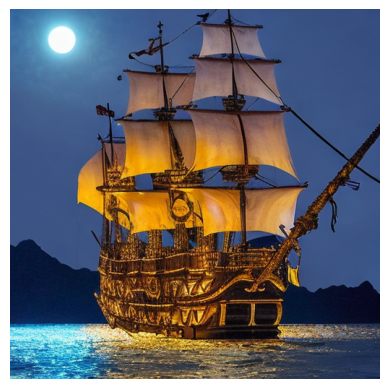

In [6]:
from matplotlib import pyplot as plt

# Generate an image
image = pipe(prompt, guidance_scale=guidance_scale, latents=latents_0).images

# Visualize the image using Matplotlib
plt.imshow(image[0])
plt.axis('off')  # Hide axes
plt.show()
